In [352]:
import neptune_query as nq
from neptune_query.filters import Filter


nq.fetch_experiments_table(
    project="leo/pytorch-tutorial",
    experiments=Filter.contains_all(
        "sys/tags",
        ["pretraining"]
    ),
    attributes=".*loss"
)

nq.list_experiments(
    project="leo/pytorch-tutorial",
    experiments=r".*distributed"
    )


['pretraining-gpt2-distributed',
 'pretraining-gpt2-distributed-2xA100',
 'pretraining-gpt2-distributed-2xRTX5000',
 'pretraining-gpt2-distributed-4xA100',
 'pretraining-gpt2-distributed-4xA5000Pro',
 'pretraining-gpt2-distributed-4xRTX5000']

In [1]:
import neptune_query.runs as nq_runs
from neptune_query.filters import Filter, AttributeFilter

'''tags = Filter.contains_all("sys/tags", ["pretraining", "distributedx2", "distributedx4"])
creation_date = Filter.gt("sys/creation_time", "2025-08-01T12:00:00Z")
filters = tags & creation_date'''
tags_distributed = Filter.contains_all("sys/tags", ["pretraining", "distributedx2"]) | Filter.contains_all("sys/tags", ["pretraining", "distributedx4"])
metrics_filter = Filter.gt("train/loss", 0)

filters = tags_distributed & metrics_filter
run_list = nq_runs.list_runs(
    project="leo/pytorch-tutorial",
    runs=filters
)
print(len(run_list))

attributes_filter = r"gradient_accumulation_steps | gpu_num | max_token_length | per_device_train_batch_size | runtime/details/gpu/1/name"

run_tbl = nq_runs.fetch_runs_table(
    project="leo/pytorch-tutorial",
    runs=run_list,
    attributes=attributes_filter
)
run_tbl.reset_index().head()



27


,run,config/gradient_accumulation_steps,config/max_token_length,config/per_device_train_batch_size,runtime/details/gpu/1/name,runtime/details/gpu_num,training_args/gradient_accumulation_steps,training_args/per_device_train_batch_size
0,viable-optimizer-20250901115719017-725sw,16,1024.0,8,NVIDIA RTX A5000,4,NaN,NaN
1,magnetic-sensor-20250901115318875-v507n,16,1024.0,8,NVIDIA RTX A5000,4,NaN,NaN
2,petite-optimizer-20250901113220606-b96io,16,1024.0,8,NVIDIA RTX A5000,4,NaN,NaN
3,seasoned-module-20250901080840648-opsn8,16,1024.0,8,NVIDIA A100-PCIE-40GB,4,NaN,NaN
4,evaluated-particle-20250901075629223-l305k,16,1024.0,8,NVIDIA A100-PCIE-40GB,4,NaN,NaN


In [398]:

metrics_df = nq_runs.fetch_metrics(
    runs=run_list,  # run ID
    attributes=r"train/loss | train & tokens",
    #step_range=(1000.0, None),
    include_point_previews=False,
    include_time="absolute"
)

metrics_df = metrics_df.reset_index()
metrics_df.head()

run step  \
                                                
0  centered-star-20250829154427580-nc3sz  1.0   
1  centered-star-20250829154427580-nc3sz  2.0   
2  centered-star-20250829154427580-nc3sz  3.0   
3  centered-star-20250829154427580-nc3sz  4.0   
4  centered-star-20250829154427580-nc3sz  5.0   

                        train/loss              train/num_input_tokens_seen  \
                     absolute_time   value                    absolute_time   
0 2025-08-29 15:44:47.703000+00:00  3.2023 2025-08-29 15:44:47.703000+00:00   
1 2025-08-29 15:45:12.771000+00:00  6.8041 2025-08-29 15:45:12.771000+00:00   
2 2025-08-29 15:45:37.865000+00:00  6.0897 2025-08-29 15:45:37.865000+00:00   
3 2025-08-29 15:46:02.476000+00:00  4.6327 2025-08-29 15:46:02.476000+00:00   
4 2025-08-29 15:46:27.130000+00:00  4.0043 2025-08-29 15:46:27.130000+00:00   

             train/train_tokens_per_second        
       value                 absolute_time value  
0  1179648.0                           NaT   NaN  
1  2359296.0                           NaT   NaN  
2  3538944.0                           NaT   NaN  
3  4718592.0                           NaT   NaN  
4  5898240.0                           NaT   NaN

In [399]:
# Cell 1: Simple function to calculate step duration statistics
import pandas as pd
import numpy as np

def calculate_step_duration_stats(df):
    """Calculate mean and std of step durations for each run."""
    result_dfs = []
    
    for run_id in df['run'].unique():
        run_data = df[df['run'] == run_id].copy()
        
        # Sort by step to ensure chronological order
        run_data = run_data.sort_values('step')
        
        # Convert time to datetime if it's not already
        if not pd.api.types.is_datetime64_any_dtype(run_data["train/loss"]["absolute_time"]):
            run_data["train/loss"]['absolute_time'] = pd.to_datetime(run_data["train/loss"]['absolute_time'])
        
        # Calculate relative time (seconds since start)
        start_time = run_data['train/loss']['absolute_time'].min()
        run_data['relative_time'] = (run_data['train/loss']['absolute_time'] - start_time).dt.total_seconds()
        
        # Calculate step duration (time between consecutive steps)
        run_data['step_duration'] = run_data['relative_time'].diff()
        
        result_dfs.append(run_data)
    
    # Combine all runs
    combined_df = pd.concat(result_dfs, ignore_index=True)
    
    # Calculate statistics grouped by run
    stats = combined_df.groupby('run')['step_duration'].agg(['mean', 'std']).round(4)
    stats.columns = ['mean_step_duration', 'std_step_duration']
    
    # Add throughput (steps per second)
    stats['mean_throughput'] = (1.0 / stats['mean_step_duration']).round(4)
    
    return stats


def calculate_token_diff(df):
    """Calculate token differences between consecutive rows for each run."""
    result_dfs = []
    
    for run_id in df['run'].unique():
        run_data = df[df['run'] == run_id].copy()
        
        # Sort by step to ensure chronological order
        run_data = run_data.sort_values('step')

        # Convert time to datetime if it's not already
        if not pd.api.types.is_datetime64_any_dtype(run_data["train/loss"]["absolute_time"]):
            run_data["train/loss"]['absolute_time'] = pd.to_datetime(run_data["train/loss"]['absolute_time'])
        
        # Calculate relative time (seconds since start)
        start_time = run_data['train/loss']['absolute_time'].min()
        run_data['relative_time'] = (run_data['train/loss']['absolute_time'] - start_time).dt.total_seconds()
        
        # Calculate step duration (time between consecutive steps)
        run_data['step_duration'] = run_data['relative_time'].diff()
        
        # Calculate token difference between consecutive rows
        run_data['token_diff'] = run_data['train/num_input_tokens_seen']["value"].diff()

        # Calculate throughout for each run
        run_data['tokens_per_second'] = run_data['token_diff'] / run_data['step_duration']
        
        result_dfs.append(run_data)
    
    combined_df = pd.concat(result_dfs, ignore_index=True)

    # Calculate statistics grouped by run
    stats = combined_df.groupby('run')['tokens_per_second'].agg(['mean', 'std']).round(4)
    stats.columns = ['mean_throughput', 'std_throughput']
    
    # Add throughput (tokens per second)
    # stats['mean_throughput'] = (1.0 / stats['mean_throughput']).round(4)
    return stats


In [450]:
token_stats = calculate_token_diff(metrics_df)
token_stats.reset_index().head()

,run,mean_throughput,std_throughput
0,centered-star-20250829154427580-nc3sz,50238.2759,6227.5801
1,computed-graph-20250831181906958-64vwm,9726.0742,781.1857
2,core-unit-20250831162458467-87a2u,15453.5010,10183.1626
3,corporate-gorilla-20250829124858324-v6iyj,388.4581,2.2433
4,disruptive-mass-20250829144931937-ughmr,2563.0519,704.5381


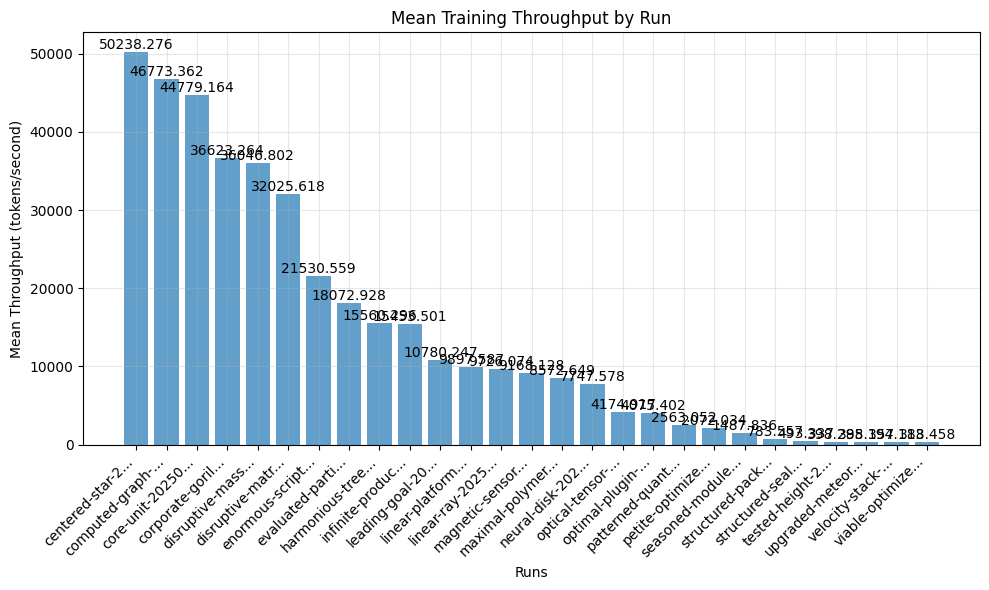

In [463]:

# Cell 3: Optional - Simple plot of mean throughput
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
runs = token_stats.index
throughput = token_stats['mean_throughput'].sort_values(ascending=False)

plt.bar(range(len(runs)), throughput, alpha=0.7)
plt.xlabel('Runs')
plt.ylabel('Mean Throughput (tokens/second)')
plt.title('Mean Training Throughput by Run')
plt.xticks(range(len(runs)), [run[:15] + '...' for run in runs], rotation=45, ha='right')
plt.grid(True, alpha=0.3)

# Add value labels on bars
for i, value in enumerate(throughput):
    plt.text(i, value + 0.01, f'{value:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [442]:
gpu_costs = pd.DataFrame({
    'gpu_type': ['NVIDIA A100-PCIE-40GB', 'Quadro RTX 5000', 'NVIDIA RTX A5000'],
    'cost_per_hour': [1.29, 0.39, 0.49]
})

print(gpu_costs)

                gpu_type  cost_per_hour
0  NVIDIA A100-PCIE-40GB           1.29
1        Quadro RTX 5000           0.39
2       NVIDIA RTX A5000           0.49


In [462]:
# Join the dataframes
# First join token_stats with run_tbl to get GPU type for each run
merged_df = token_stats.reset_index().merge(
    run_tbl.reset_index()[['run', 'runtime/details/gpu_num','runtime/details/gpu/1/name']], 
    on='run', 
    how='left'
)

# Then join with gpu_costs to get cost per hour
final_df = merged_df.merge(
    gpu_costs, 
    left_on='runtime/details/gpu/1/name', 
    right_on='gpu_type', 
    how='left'
)

# Calculate cost for processing 1 billion tokens
billion_tokens = 1_000_000_000

# Time to process 1 billion tokens (in hours)
final_df['hours_to_process_1b_tokens'] = billion_tokens / (final_df['mean_throughput'] * 3600)

# Total cost for processing 1 billion tokens
final_df['cost_for_1b_tokens'] = final_df['hours_to_process_1b_tokens'] * final_df['runtime/details/gpu_num'] * final_df['cost_per_hour'] 

# Display results sorted by cost
final_df.sort_values('cost_for_1b_tokens').round(4).head()

,run,mean_throughput,std_throughput,runtime/details/gpu_num,runtime/details/gpu/1/name,gpu_type,cost_per_hour,hours_to_process_1b_tokens,cost_for_1b_tokens
13,magnetic-sensor-20250901115318875-v507n,36623.2635,1415.7438,4,NVIDIA RTX A5000,NVIDIA RTX A5000,0.49,7.5847,14.8661
19,petite-optimizer-20250901113220606-b96io,36046.8021,1147.0020,4,NVIDIA RTX A5000,NVIDIA RTX A5000,0.49,7.7060,15.1038
26,viable-optimizer-20250901115719017-725sw,32025.6178,5129.7427,4,NVIDIA RTX A5000,NVIDIA RTX A5000,0.49,8.6736,17.0003
6,enormous-script-20250829152609864-41gee,9168.1278,2810.6469,2,Quadro RTX 5000,Quadro RTX 5000,0.39,30.2982,23.6326
24,upgraded-meteor-20250831165427292-k7vny,18072.9279,2488.7819,4,Quadro RTX 5000,Quadro RTX 5000,0.39,15.3698,23.9769


In [ ]:
from neptune_scale import Run

run = Run(
    project="leo/pytorch-tutorial",
    run_id="textured-bear-20250903151016458-cjp2t")

run.log_configs(
    {}

2025-09-04 22:13:31,870 neptune:INFO: View your run in the app:
https://scale.neptune.ai/leo/pytorch-tutorial/-/run/?customId=textured-bear-20250903151016458-cjp2t


2025-09-04 22:13:38,595 neptune:ERROR: 

NeptuneRunConflicting: Run with specified `run_id` already exists, but has a different `fork_run_id` parameter.

For forking instructions, see https://docs.neptune.ai/fork_experiment

2025-09-04 22:13:39,852 neptune:ERROR: SyncProcess died.
2025-09-04 22:13:39,896 neptune:ERROR: 

NeptuneSynchronizationStopped: The background synchronization process has stopped unexpectedly.


Your data is still being saved locally. You can manually synchronize it with the
Neptune backend later by running `neptune sync`.

